# MNIST Digit Recognizer Lab
From [Deep Learning web app](https://medium.com/@rhome/deep-learning-web-app-63904aea7a4e) Medium Tutorial

## Loading the mnist dataset

In [39]:
import numpy as np
import tensorflow as tf

print("Loading mnist dataset...")
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.
# add a channels dimension
X_train = X_train[..., tf.newaxis]
X_test = X_test[..., tf.newaxis]
print('Data loaded. X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print("Done.")
print('Data loaded. X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print("Done.")

Loading mnist dataset...
Data loaded. X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Done.
Data loaded. X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Done.


## Showing dataset sample

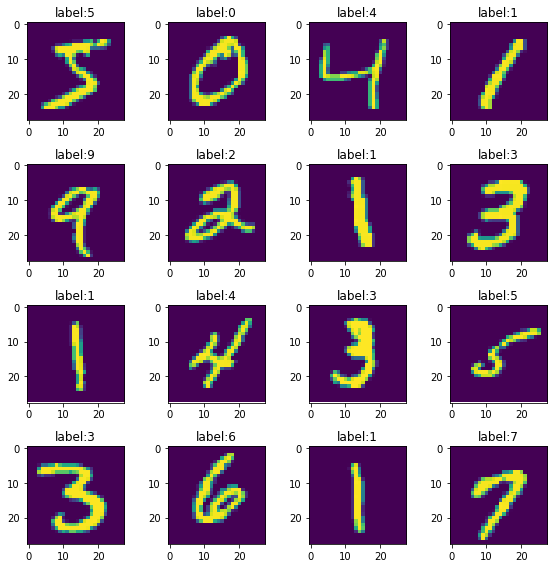

In [40]:
from matplotlib import pyplot as plt

# Showing dataset sample

w = 10
h = 10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 4
for i in range(0, columns*rows):
    img = X_train[i]
    ax = fig.add_subplot(rows, columns, i+1)
    ax.title.set_text('label:' + str(y_train[i]))
    plt.imshow(img)
plt.tight_layout()
plt.show()

## Creating model

In [41]:
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from datetime import datetime

# convert class vectors to binary class matrices
num_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# create model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)              

## Choosing loss function, an optimizer, and training the model

In [42]:
# choose a loss function and an optimizer
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

# (optional) configure tensorboard to collect training stats
log_dir = "C:\\temp\\tensorboard\\{}".format(datetime.now().strftime("%Y%m%d-%H%M%S"))
os.mkdir(log_dir)
tensorboardCallback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

# start training
print("Start training model...")
model.fit(X_train, y_train,
          batch_size=512,
          epochs=2,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks=[tensorboardCallback])

# evaluate the trained model
print("Model trained. Evaluating on test set...")
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Start training model...
Epoch 1/2
118/118 [==============================] - 55s 463ms/step - loss: 0.3995 - accuracy: 0.8783 - val_loss: 0.0808 - val_accuracy: 0.9746
Epoch 2/2
118/118 [==============================] - 57s 482ms/step - loss: 0.1134 - accuracy: 0.9671 - val_loss: 0.0497 - val_accuracy: 0.9842
Model trained. Evaluating on test set...
Test loss: 0.04965515434741974
Test accuracy: 0.9842000007629395


## Save model

In [43]:
model.save("my_model.h5")

## Model Deployment

In [ ]:
import flask
from flask_cors import CORS
from werkzeug.utils import cached_property #**must come be imported flask_restplus**
from flask_restplus import Api, Resource, fields
import tensorflow as tf
from skimage.transform import resize
import numpy as np

# disable GPU usage for inference
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

app = flask.Flask(__name__)
CORS(app)
app.config["DEBUG"] = False
api = Api(app,
          version='1.0',
          title='Digits Recognition API',
          description='An API to recognize hand written digits.'
)
ns = api.namespace('api/v1/digits', description='Digit recognition operations')

# create API schema
preditionRequest = api.model('PreditionRequest', {
    'image': fields.List(fields.Integer, required=True, description='1D flattened array of grey-scaled pixel values, between 0 and 255'),
    'imageWidth': fields.Integer(required=True, description='image width, in pixels'),
    'imageHeigth': fields.Integer(required=True, description='image heigth, in pixels')
})
preditionResponse = api.model('PreditionResponse', {
    'success': fields.Boolean,
    'digit': fields.Integer(description='the predicted digit, between 0 and 9'),
    'probas': fields.List(fields.Float, description='array of probabilities for each digit, between 0 and 1')
})

# load trained model
print("Loading model...")
# model = tf.keras.models.load_model("C:\TEMP\mnist_model.h5")
model = tf.keras.models.load_model("my_model.h5")
print("Model loaded. Starting server...")

@ns.route('/health-check', methods=['GET'])
class HealthCheck(Resource):
    def get(self):
        # return default HTTP code 200
        return

@ns.route('/predict', methods=['POST'])
class DigitRecognizer(Resource):

    @ns.expect(preditionRequest)
    @ns.marshal_with(preditionResponse, code=201)
    def post(self):
        try:
            print("**************** NEW REQUEST RECEIVED ****************")
            req = api.payload
            image = np.reshape(np.array(req['image']), (128, 128))
            image = resize(image, (28, 28), anti_aliasing=True, preserve_range=True)
            image = image / 255.0
            image = np.reshape(image, (1, 28, 28, 1))
            print('Running predictions on image with size', image.shape)
            probabilities = model.predict(image)
            digit = np.argmax(probabilities)
            result = {'success': True, 'digit': int(digit), 'probas': probabilities[0].tolist()}
        except Exception as e:
            result = {'status': False, 'error': str(e)}
        print('>>> result:', result)
        return result, 201


if __name__ == '__main__':
    app.run()

Loading model...
Model loaded. Starting server...
 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [16/Feb/2021 21:33:14] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [16/Feb/2021 21:33:14] "GET /swaggerui/droid-sans.css HTTP/1.1" 200 -
127.0.0.1 - - [16/Feb/2021 21:33:14] "GET /swaggerui/swagger-ui.css HTTP/1.1" 200 -
127.0.0.1 - - [16/Feb/2021 21:33:14] "GET /swaggerui/swagger-ui-standalone-preset.js HTTP/1.1" 200 -
127.0.0.1 - - [16/Feb/2021 21:33:14] "GET /swaggerui/swagger-ui-bundle.js HTTP/1.1" 200 -
127.0.0.1 - - [16/Feb/2021 21:33:14] "GET /swagger.json HTTP/1.1" 200 -
127.0.0.1 - - [16/Feb/2021 21:33:14] "GET /swaggerui/favicon-32x32.png HTTP/1.1" 200 -


### Notes
- Error: I had to install `fask-cors`
```
pip3 install -U flask-cors
```
- Error: I had to install `flask_restplus`
```
pip3 install flask-restplus
```
- Error: `cannot import name 'cached_property' from 'werkzeug'`
    - Fixed by importing `cached_property` **before** `flask_restplus` like below
    ```
    from werkzeug.utils import cached_property 
    from flask_restplus import Api, Resource, fields
    ``` 
- Error: No module named 'skimage'
```
pip3 install scikit-image
```
- Error: OSError: SavedModel file does not exist at: C:\TEMP\mnist_model.h5/{saved_model.pbtxt|saved_model.pb}
